In this notebook we illustrate how **regular training** is performed in our experiments, write the script to train in a range of (small) training samples and plot the results of this script.

## How is it organized?

1. In the first section notebook we illustrate the scenario were ImageNet is used with gradual unfreezing for the whole dataset. This is useful to test how the model behaves when all the data is available. 

2. In the second section the script is written and we explore different alternatives in transfer learning for a range of training data. We do so by combining regular training with multiple alternatives in transfer learning:

    * Is transfer learning used? If so, from what dataset?  We contemplate ImageNet and MURA (general and medical images respectively).
    * How is transfer learning done? previous CNN as feature extractor, fine-tune CNN? If we fine-tune, do we use differential learning rates?
    * Do we do progressive unfreezing?

 Some of those options are excluding and other are complementary. For instance, no transfer learning and using the previous CNN as feature extractor are excluding.

3. In the last section we plot the results of running the script.

## I want to dig deeper

This notebook's main purpose is illustrating how **regular training** is used. All other aspects are imported from `data_manipulation`,`utils`, `architectures` and `train_functions`. If the reader wants to dig dipper in aspects such as how data augmentation is implemented, what policy we use for the learning rate or how the optimizer is used we point them to the modules mentioned above. 



# Using all the available data
## Imports & global variables

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import sys; sys.path.append("/data/miguel/practicum/DL-Medical-Physics")
import warnings; warnings.filterwarnings('ignore')

from core import *
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_multilabel, lr_finder

BATCH_SIZE = 16
EPOCHS = 20
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
PRETRAINED = False
FREEZE = False
GRADUAL_UNFREEZING = False

BASE_PATH = Path('/data/miguel/practicum/')
PATH = BASE_PATH/'data'
SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/models'
# SAVE_PLOT = Path('../latest_plots/14diseases-app1')

IMG_FOLDER = PATH/'ChestXRay-250'
DATA = '14diseases'

## Data Batches

In [2]:
# data preparation
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_dl = DataBatches(train_df, img_folder_path=IMG_FOLDER,transforms=TRANSFORMATIONS, 
                       shuffle=True, data=DATA,batch_size=BATCH_SIZE, normalize=PRETRAINED)

valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER, transforms = False,
                       shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)

test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
                      shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)

## LR Finder

A Jupyter Widget

A Jupyter Widget

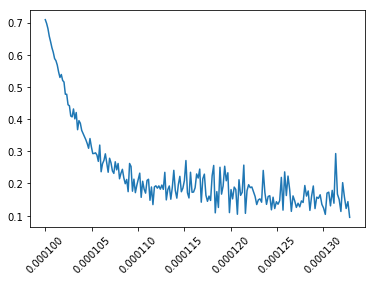

In [3]:
model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()
lrs, losses  = lr_finder(model, 1, train_dl)

## Training & Testing

In [4]:
# training loop: definition
def regular_training(epochs, train_dl, valid_dl, model, save_path=None,
          min_lr=1e-6, max_lr=0.001, epsilon=.001, unfreeze_during_loop:tuple=None):
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
        
    
    for epoch in tqdm_notebook(range(epochs)):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in tqdm_notebook(train_dl, leave=False):
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < min_lr:
            break

In [5]:
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def one_cycle_train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

In [10]:
# training loop: execution


transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=IMG_FOLDER,transforms=TRANSFORMATIONS,
                       shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)


model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()
save_path = None
regular_training(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path)

In [ ]:
load_model(model, save_pathc)
test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
                      shuffle = False, data=data, batch_size = BATCH_SIZE, normalize=PRETRAINED)
TTA_multilabel(model, test_dl)

In [ ]:
model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = None
one_cycle_train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None, alpha=1)

In [ ]:
load_model(model, save_pathc)
test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms = TRANSFORMATIONS, 
                      shuffle = False, data=DATA, batch_size = BATCH_SIZE, normalize=PRETRAINED)
TTA_multilabel(model, test_dl)

# Sample range: Writing script

We will train the different combinations on a script. Observe that we have constructed the training function 

In [11]:
! pwd

/data/miguel/practicum/DL-Medical-Physics/training_methods


In [2]:
%%writefile chestxray14.py

import sys; sys.path.append("/data/miguel/practicum/DL-Medical-Physics")

from core import *
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_multilabel, TTA_multilabel
import json

BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
DATA = '14diseases'

SAMPLE_AMOUNTS = [50,100,200,400,600,800,1000,1200,1400,1600,1800,2000]

BASE_PATH = Path('/data/miguel/practicum/')
PATH = BASE_PATH/'data'
SAVE_DIRECTORY = BASE_PATH/'DL-Medical-Physics/training_methods/models'
SAVE_DATA = BASE_PATH/'DL-Medical-Physics/training_methods/results'
IMG_FOLDER = PATH/'ChestXRay-250'
PRETRAINED = False
FREEZE = False
GRADUAL_UNFREEZING = False

def regular_training(epochs, train_dl, valid_dl, model, save_path=None,
          min_lr=1e-6, max_lr=0.001, epsilon=.001, unfreeze_during_loop:tuple=None):
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
        
    
    for epoch in range(epochs):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in train_dl:
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < min_lr:
            break

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def one_cycle_train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training            
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")

valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER,transforms=False, 
                       shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

train_df = train_df.sample(frac=1)

for N in SAMPLE_AMOUNTS:

    df = train_df[:N]

    train_dl = DataBatches(df, img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS, 
                           shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

    model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    save_path = SAVE_DIRECTORY/f"chestxray14-regular-training-{N}.pth"

    regular_training(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path)
    
    model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    save_path = SAVE_DIRECTORY/f"chestxray14-one-cycle-training-{N}.pth"
    
    one_cycle_train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None, alpha=1)
    
    
# Evaluation

test_df = pd.read_csv(PATH/"test_df.csv")

regular_training = {
    'losses':[],
    'aucs':[]
}
one_cycle_training = {
    'losses':[],
    'aucs':[]
}

test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS, 
                      shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

for N in SAMPLE_AMOUNTS:

    model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()

    load_path = SAVE_DIRECTORY/f"chestxray14-regular-training-{N}.pth"

    load_model(model, load_path)

    loss, mean_auc, _ = TTA_multilabel(model, test_dl, ndl=4)

    regular_training['losses'].append(loss)
    regular_training['aucs'].append(mean_auc)

    load_path = SAVE_DIRECTORY/f"chestxray14-one-cycle-training-{N}.pth"

    load_model(model, load_path)

    loss, mean_auc, _ = TTA_multilabel(model, test_dl, ndl=4)

    one_cycle_training['losses'].append(loss)
    one_cycle_training['aucs'].append(mean_auc)

regular_training = json.dumps(regular_training)
with open('results/chestxray14_regular_training.json', 'w') as f:
    f.write(regular_training)

one_cycle_training = json.dumps(one_cycle_training)
with open('results/chestxray14_one_cycle_training.json', 'w') as f:
    f.write(one_cycle_training)

Overwriting chestxray14.py


# Plot results